In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
#With discharge
file_path = r"y_obs.csv"
y_obs = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_obs.set_index(y_obs.columns[0],inplace=True)
file_path = r'y_sim.csv'
y_sim = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_sim.set_index(y_sim.columns[0],inplace=True)
file_path = rf"..\without_discharge_eobs\y_sim.csv"
y_sim_no_disch = pd.read_csv(file_path, parse_dates=[0])
# Set the unnamed first column (dates) as the index
y_sim_no_disch.set_index(y_sim_no_disch.columns[0],inplace=True)


In [3]:
def calculate_nse_thresholds(y_obs_df, y_sim_df):
    """Calculate NSE for each catchment with thresholds >1 and >5."""
    nse1_values = []
    nse5_values = []

    for catchment in y_obs_df.columns:
        y_obs = y_obs_df[catchment].values
        y_sim = y_sim_df[catchment].values

        # Mask NaN values
        valid_mask = ~np.isnan(y_obs) & ~np.isnan(y_sim)
        y_obs = y_obs[valid_mask]
        y_sim = y_sim[valid_mask]

        # NSE for values > 1
        mask_gt1 = (y_obs > 1) & (y_sim > 1)
        if np.sum(mask_gt1) > 180:
            obs1 = y_obs[mask_gt1]
            sim1 = y_sim[mask_gt1]
            nse1 = 1 - np.sum((sim1 - obs1)**2) / np.sum((obs1 - np.mean(obs1))**2)
            nse1 = round(nse1, 3)
        else:
            nse1 = np.nan

        # NSE for values > 5
        mask_gt5 = (y_obs > 5) & (y_sim > 5)
        if np.sum(mask_gt5) > 180:
            obs5 = y_obs[mask_gt5]
            sim5 = y_sim[mask_gt5]
            nse5 = 1 - np.sum((sim5 - obs5)**2) / np.sum((obs5 - np.mean(obs5))**2)
            nse5 = round(nse5, 3)
        else:
            nse5 = np.nan

        nse1_values.append(nse1)
        nse5_values.append(nse5)

    return pd.DataFrame({
        'Catchment': y_obs_df.columns,
        'NSE_gt1': nse1_values,
        'NSE_gt5': nse5_values
    })


In [4]:
nse_disch = calculate_nse_thresholds(y_obs, y_sim)
nse_without_disch = calculate_nse_thresholds(y_obs, y_sim_no_disch)

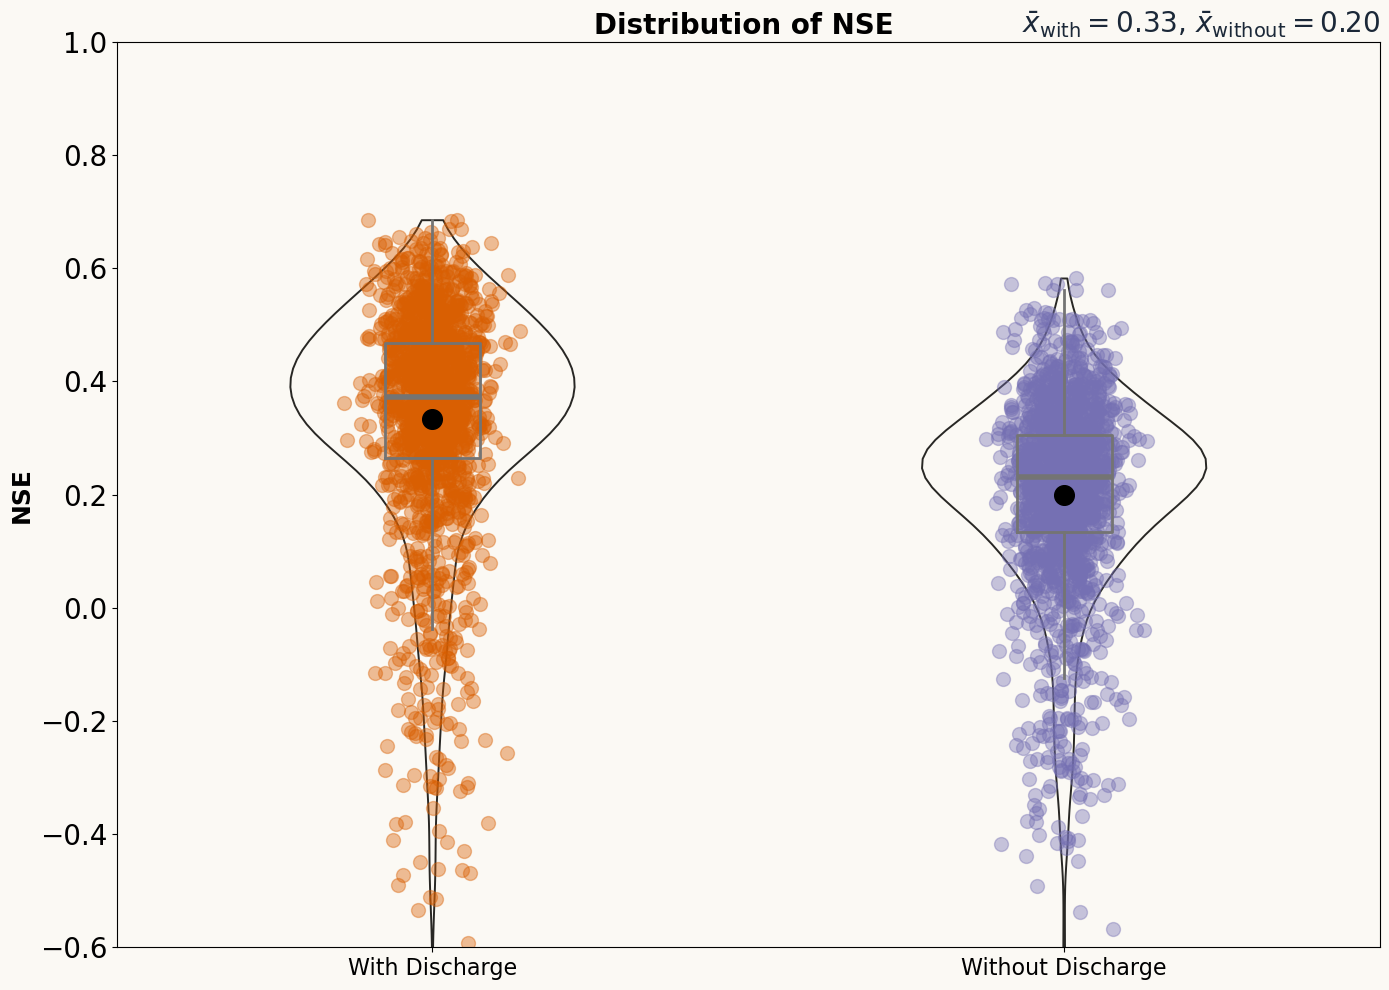

In [5]:
# Define colors and layout constants
# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"
POSITIONS = [1, 2]  # Positions for the violin plots
HLINES = np.arange(-0.5, 1.1, 0.1)  # Horizontal lines for reference

nse_disch_values = nse_disch['NSE_gt1'].dropna()
nse_without_disch_values = nse_without_disch['NSE_gt1'].dropna()

#nse_disch_values = nse_disch_values[nse_disch_values >= 0]  # Keep only non-negative values
#nse_without_disch_values = nse_without_disch_values[nse_without_disch_values >= 0]  # Keep only non-negative values

# Data for plotting
y_data = [nse_disch_values, nse_without_disch_values]
x_jittered = [np.random.normal(pos, 0.04, size=len(y)) for pos, y in zip(POSITIONS, y_data)]

# Colors taken from Dark2 palette in RColorBrewer R library
COLOR_SCALE = [ "#D95F02", "#7570B3"]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10))

# Background color
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)


# Add violins
violins = ax.violinplot(
    y_data, 
    positions=POSITIONS,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violins
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)

# Add boxplots
medianprops = dict(
    linewidth=4, 
    color=GREY_DARK,
    solid_capstyle="butt"
)
boxprops = dict(
    linewidth=2, 
    color=GREY_DARK
)

ax.boxplot(
    y_data,
    positions=POSITIONS, 
    showfliers=False,  # Do not show the outliers beyond the caps
    showcaps=False,    # Do not show the caps
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops
)

# Add jittered dots
for x, y, color in zip(x_jittered, y_data, COLOR_SCALE):
    ax.scatter(x, y, s=100, color=color, alpha=0.4)

# Calculate and plot the mean
means = [np.mean(y) for y in y_data]

# Plot the means as red circles
ax.scatter(POSITIONS, means, color='black', s=200, zorder=3, label='Mean')


# Customize labels
ax.set_xticks(POSITIONS)
ax.tick_params(axis='both', labelsize=20)
ax.set_xticklabels(['With Discharge', 'Without Discharge'], size=16)
ax.set_ylabel('NSE', size=18, weight='bold')
ax.set_ylim([-0.6,1])
ax.set_title('Distribution of NSE ', size=20, weight='bold')

# Subtitle
subtitle_stats = [
    r"$\bar{x}_{\rm{with}}=%.2f$" % np.mean(nse_disch_values),
    r"$\bar{x}_{\rm{without}}=%.2f$" % np.mean(nse_without_disch_values)
]

ax.set_title(
    ", ".join(subtitle_stats),
    loc="right",
    ha="right",
    fontsize=20,
    color=BLUE_DARK
)

# Adjust layout
plt.tight_layout()
#plt.savefig('violin_plot.jpeg', dpi =1200)
plt.show()


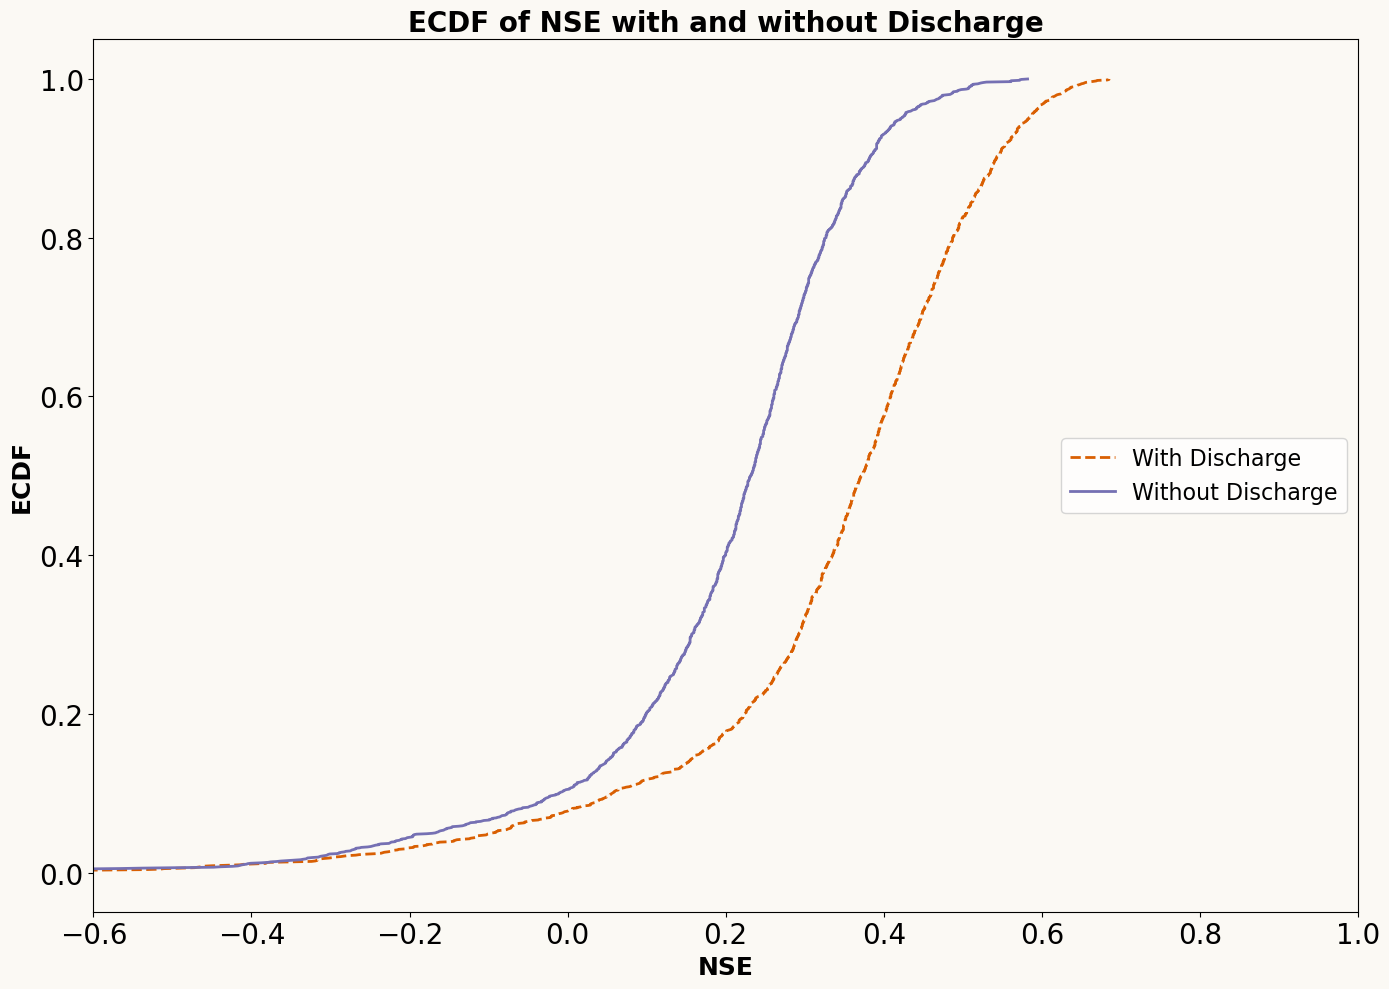

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF

# Define colors and layout constants
# Colors
BG_WHITE = "#fbf9f4"
GREY_LIGHT = "#b4aea9"
GREY50 = "#7F7F7F"
BLUE_DARK = "#1B2838"
BLUE = "#2a475e"
BLACK = "#282724"
GREY_DARK = "#747473"
RED_DARK = "#850e00"

COLOR_SCALE = [ "#D95F02", "#7570B3"]

def plot_ecdf(nse_disch, nse_without_disch):
    # Extract and clean NSE column from both dataframes, removing NaN and negative values
    nse_disch_values = nse_disch['NSE_gt1'].dropna()
    #nse_disch_values = nse_disch_values[nse_disch_values >= 0]  # Keep only non-negative values

    nse_without_disch_values = nse_without_disch['NSE_gt1'].dropna()
    #nse_without_disch_values = nse_without_disch_values[nse_without_disch_values >= 0]  # Keep only non-negative values

    # Calculate the ECDF using statsmodels
    ecdf_disch = ECDF(nse_disch_values)
    ecdf_without_disch = ECDF(nse_without_disch_values)

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 10))

    # Background color
    fig.patch.set_facecolor(BG_WHITE)
    ax.set_facecolor(BG_WHITE)


    # Plot ECDF for nse_disch
    ax.plot(ecdf_disch.x, ecdf_disch.y, label='With Discharge', color="#D95F02", lw=2,linestyle='dashed')

    # Plot ECDF for nse_without_disch
    ax.plot(ecdf_without_disch.x, ecdf_without_disch.y, label='Without Discharge', color="#7570B3", lw=2)

    # Add labels and legend
    ax.set_xlabel('NSE', size=18, weight='bold')
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlim([-0.6, 1])  # Limit x-axis to range 0 to 1
    ax.set_ylabel('ECDF', size=18, weight='bold')
    ax.set_title('ECDF of NSE with and without Discharge', size=20, weight='bold')
    ax.legend(loc='center right', fontsize=16)

    # Increase the font size of the ticks
    ax.tick_params(axis='both', which='major', labelsize=20)  # Set font size for both axes

    # Adjust layout
    # Adjust layout
    plt.tight_layout()
    #plt.savefig('ecdf_plot.jpeg', dpi =1200)
    plt.show()


plot_ecdf(nse_disch, nse_without_disch)


In [8]:
# Assuming nse_without_disch and nse_disch are your input dataframes
# Merge the two dataframes on 'basin_id'
merged_df = pd.merge(nse_without_disch, nse_disch, on='Catchment', suffixes=('_without_disch', '_disch'))

# Calculate the difference between the two NSE columns
merged_df['NSE_difference_gt1'] =  merged_df['NSE_gt1_disch'] - merged_df['NSE_gt1_without_disch'] 
merged_df['NSE_difference_gt5'] =  merged_df['NSE_gt5_disch'] - merged_df['NSE_gt5_without_disch'] 

# Display the result
print(merged_df)

           Catchment  NSE_gt1_without_disch  NSE_gt5_without_disch  \
0       GRDC_6140100                  0.008                 -0.379   
1       GRDC_6140101                  0.030                 -0.320   
2       GRDC_6140120                  0.167                 -0.356   
3       GRDC_6140130                  0.138                 -0.200   
4       GRDC_6140140                  0.129                 -0.275   
...              ...                    ...                    ...   
1799  camelsgb_95001                  0.336                  0.053   
1800  camelsgb_96001                  0.285                  0.101   
1801  camelsgb_96002                  0.347                  0.154   
1802  camelsgb_96004                  0.268                  0.005   
1803  camelsgb_97002                  0.213                  0.052   

      NSE_gt1_disch  NSE_gt5_disch  NSE_difference_gt1  NSE_difference_gt5  
0             0.256         -0.055               0.248               0.324  
1    

In [11]:
merged_df.to_csv("result_NSE_differences_grt15.csv")

In [12]:
merged_df_original=pd.read_csv("result_NSE_differences.csv", index_col=0)

In [13]:
merged_df_original

,Catchment,NSE_without_disch,NSE_disch,NSE_difference
0,GRDC_6140100,0.453,0.590,0.137
1,GRDC_6140101,0.471,0.646,0.175
2,GRDC_6140120,0.522,0.639,0.117
3,GRDC_6140130,0.492,0.657,0.165
4,GRDC_6140140,0.502,0.644,0.142
...,...,...,...,...
1799,camelsgb_95001,0.615,0.612,-0.003
1800,camelsgb_96001,0.565,0.584,0.019
1801,camelsgb_96002,0.604,0.621,0.017
1802,camelsgb_96004,0.586,0.571,-0.015


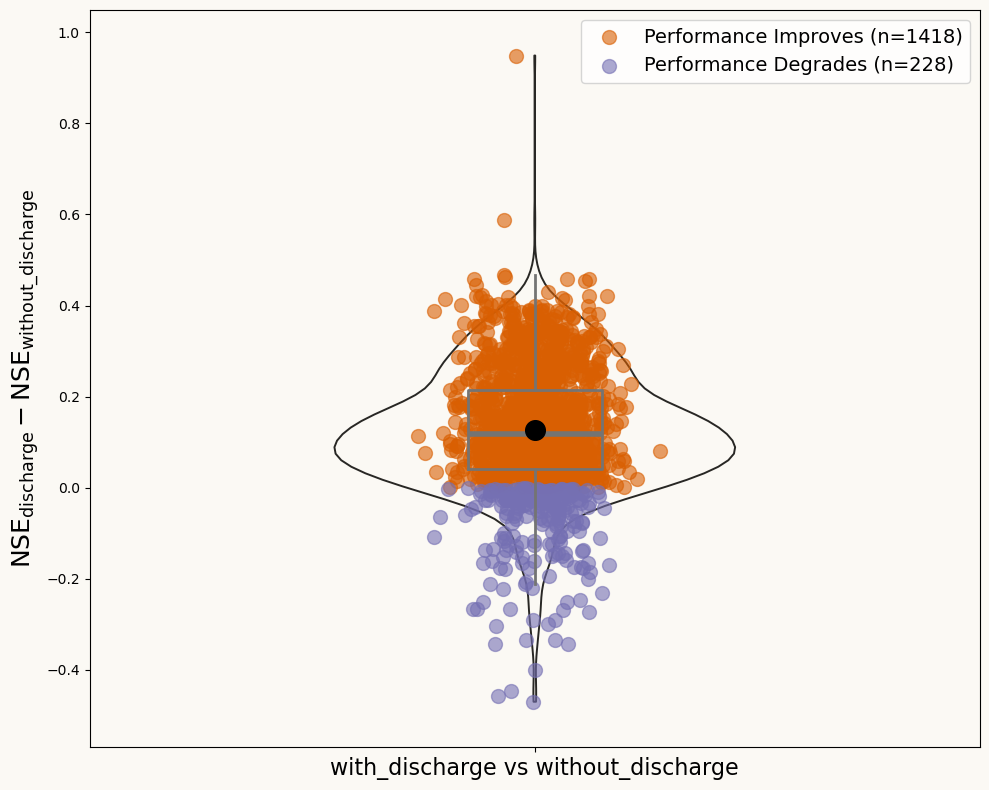

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define colors and layout constants
BG_WHITE = "#fbf9f4"
GREY_DARK = "#747473"
BLACK = "#282724"
COLOR_POSITIVE = "#D95F02" 
COLOR_NEGATIVE = "#7570B3" 
POSITION = [1]  # Single violin plot position


# Extract data
nse_difference = merged_df['NSE_difference_gt1'].dropna()

# Split data into positive and negative
positive_values = nse_difference[nse_difference >= 0]
negative_values = nse_difference[nse_difference < 0]
# Count the number of points in each category
num_positive = len(positive_values)
num_negative = len(negative_values)


# Generate jittered x-values for each group
x_jittered_positive = np.random.normal(POSITION[0], 0.04, size=len(positive_values))
x_jittered_negative = np.random.normal(POSITION[0], 0.04, size=len(negative_values))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)

# Violin plot
violins = ax.violinplot(
    [nse_difference],  
    positions=POSITION,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violin appearance
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)

# Boxplot (optional)
medianprops = dict(linewidth=4, color=GREY_DARK, solid_capstyle="butt")
boxprops = dict(linewidth=2, color=GREY_DARK)

ax.boxplot(
    [nse_difference],
    positions=POSITION, 
    showfliers=False, 
    showcaps=False, 
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops
)

# Scatter points with color distinction
ax.scatter(x_jittered_positive, positive_values, s=100, color=COLOR_POSITIVE, alpha=0.6, label=f"Performance Improves (n={num_positive})") 
ax.scatter(x_jittered_negative, negative_values, s=100, color=COLOR_NEGATIVE, alpha=0.6, label=f"Performance Degrades (n={num_negative})")

# Mean value
mean_value = np.mean(nse_difference)
ax.scatter(POSITION, [mean_value], color='black', s=200, zorder=3)

# Labels & Titles
ax.set_xticks(POSITION)
ax.set_xticklabels(['with_discharge vs without_discharge'], size=16)
ax.set_ylabel(r'$\text{NSE}_{\text{discharge}} - \text{NSE}_{\text{without_discharge}} $', size=18, weight='bold')
ax.set_ylim([min(nse_difference) - 0.1, max(nse_difference) + 0.1])


# Add legend
ax.legend(loc="upper right", fontsize=14)

# Adjust layout & save
plt.tight_layout()
#plt.savefig('violin_plot_nse_difference_colored.jpeg', dpi=1200)
plt.show()


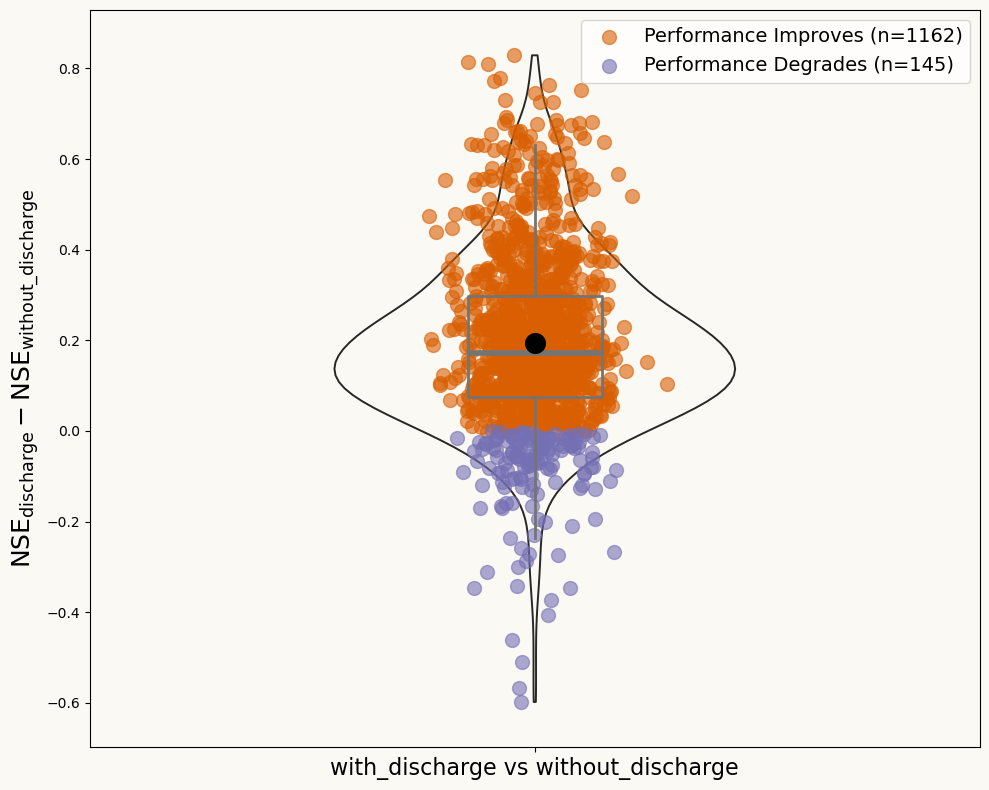

In [10]:
# Define colors and layout constants
BG_WHITE = "#fbf9f4"
GREY_DARK = "#747473"
BLACK = "#282724"
COLOR_POSITIVE = "#D95F02" 
COLOR_NEGATIVE = "#7570B3" 
POSITION = [1]  # Single violin plot position


# Extract data
nse_difference = merged_df['NSE_difference_gt5'].dropna()

# Split data into positive and negative
positive_values = nse_difference[nse_difference >= 0]
negative_values = nse_difference[nse_difference < 0]
# Count the number of points in each category
num_positive = len(positive_values)
num_negative = len(negative_values)


# Generate jittered x-values for each group
x_jittered_positive = np.random.normal(POSITION[0], 0.04, size=len(positive_values))
x_jittered_negative = np.random.normal(POSITION[0], 0.04, size=len(negative_values))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)

# Violin plot
violins = ax.violinplot(
    [nse_difference],  
    positions=POSITION,
    widths=0.45,
    bw_method="silverman",
    showmeans=False, 
    showmedians=False,
    showextrema=False
)

# Customize violin appearance
for pc in violins["bodies"]:
    pc.set_facecolor("none")
    pc.set_edgecolor(BLACK)
    pc.set_linewidth(1.4)
    pc.set_alpha(1)

# Boxplot (optional)
medianprops = dict(linewidth=4, color=GREY_DARK, solid_capstyle="butt")
boxprops = dict(linewidth=2, color=GREY_DARK)

ax.boxplot(
    [nse_difference],
    positions=POSITION, 
    showfliers=False, 
    showcaps=False, 
    medianprops=medianprops,
    whiskerprops=boxprops,
    boxprops=boxprops
)

# Scatter points with color distinction
ax.scatter(x_jittered_positive, positive_values, s=100, color=COLOR_POSITIVE, alpha=0.6, label=f"Performance Improves (n={num_positive})") 
ax.scatter(x_jittered_negative, negative_values, s=100, color=COLOR_NEGATIVE, alpha=0.6, label=f"Performance Degrades (n={num_negative})")

# Mean value
mean_value = np.mean(nse_difference)
ax.scatter(POSITION, [mean_value], color='black', s=200, zorder=3)

# Labels & Titles
ax.set_xticks(POSITION)
ax.set_xticklabels(['with_discharge vs without_discharge'], size=16)
ax.set_ylabel(r'$\text{NSE}_{\text{discharge}} - \text{NSE}_{\text{without_discharge}} $', size=18, weight='bold')
ax.set_ylim([min(nse_difference) - 0.1, max(nse_difference) + 0.1])


# Add legend
ax.legend(loc="upper right", fontsize=14)

# Adjust layout & save
plt.tight_layout()
#plt.savefig('violin_plot_nse_difference_colored.jpeg', dpi=1200)
plt.show()

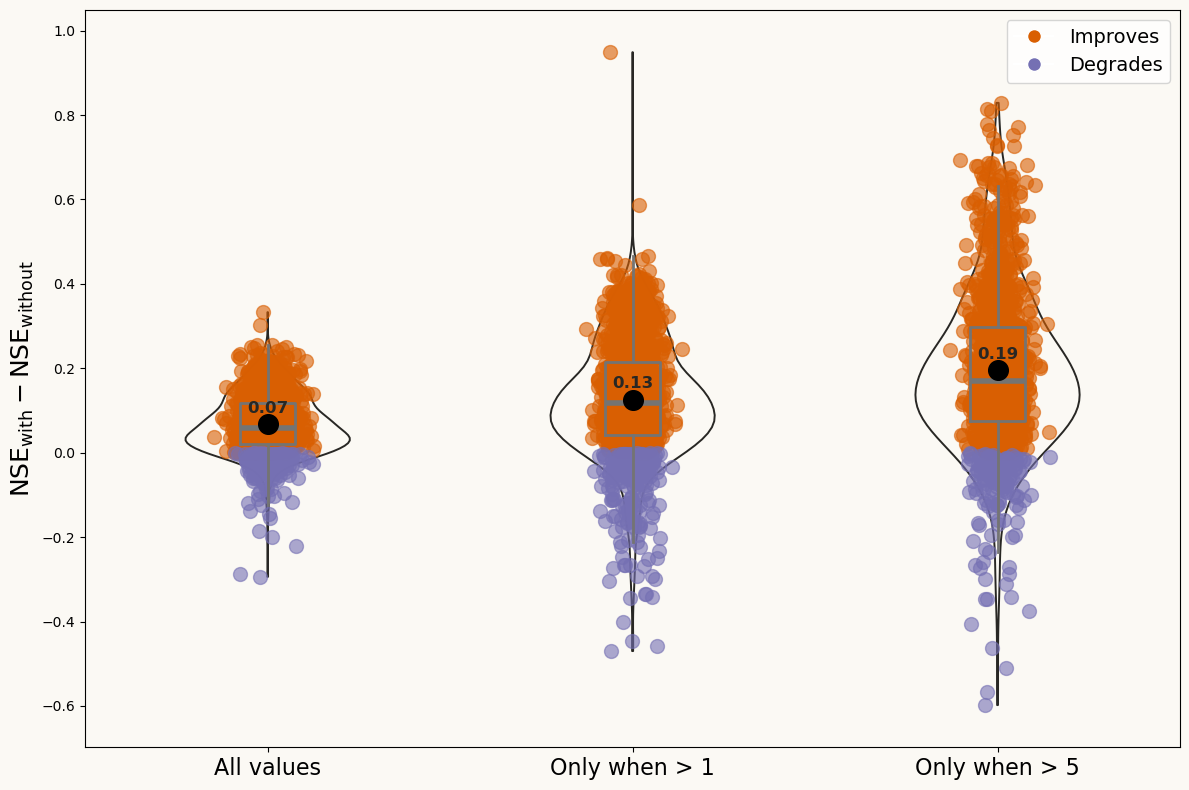

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define colors and layout constants
BG_WHITE = "#fbf9f4"
GREY_DARK = "#747473"
BLACK = "#282724"
COLOR_POSITIVE = "#D95F02"
COLOR_NEGATIVE = "#7570B3"

# Prepare data
datasets = {
    "All": merged_df_original['NSE_difference'].dropna(),
    ">1": merged_df['NSE_difference_gt1'].dropna(),
    ">5": merged_df['NSE_difference_gt5'].dropna()
}

# Set up positions and plot
positions = [1, 2, 3]
labels = list(datasets.keys())

fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor(BG_WHITE)
ax.set_facecolor(BG_WHITE)

for i, (label, nse_diff) in enumerate(datasets.items()):
    pos = positions[i]
    pos_array = [pos]
    
    # Split data
    positive_values = nse_diff[nse_diff >= 0]
    negative_values = nse_diff[nse_diff < 0]
    num_positive = len(positive_values)
    num_negative = len(negative_values)

    # Jittered points
    x_jittered_positive = np.random.normal(pos, 0.04, size=num_positive)
    x_jittered_negative = np.random.normal(pos, 0.04, size=num_negative)

    # Violin
    violins = ax.violinplot(
        [nse_diff],
        positions=pos_array,
        widths=0.45,
        bw_method="silverman",
        showmeans=False,
        showmedians=False,
        showextrema=False
    )
    for pc in violins["bodies"]:
        pc.set_facecolor("none")
        pc.set_edgecolor(BLACK)
        pc.set_linewidth(1.4)
        pc.set_alpha(1)

    # Boxplot
    medianprops = dict(linewidth=4, color=GREY_DARK, solid_capstyle="butt")
    boxprops = dict(linewidth=2, color=GREY_DARK)
    ax.boxplot(
        [nse_diff],
        positions=pos_array,
        showfliers=False,
        showcaps=False,
        medianprops=medianprops,
        whiskerprops=boxprops,
        boxprops=boxprops
    )

    # Points
    ax.scatter(x_jittered_positive, positive_values, s=100, color=COLOR_POSITIVE, alpha=0.6)
    ax.scatter(x_jittered_negative, negative_values, s=100, color=COLOR_NEGATIVE, alpha=0.6)

    # Mean marker and annotation
    mean_val = np.mean(nse_diff)
    ax.scatter(pos_array, [mean_val], color='black', s=200, zorder=3)
    ax.text(
        pos, mean_val + 0.02,  # Slight offset above the point
        f"{mean_val:.2f}",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold',
        color=BLACK
    )

# Labels & Titles
ax.set_xticks(positions)
ax.set_xticklabels([
    'All values',
    'Only when > 1',
    'Only when > 5'
], size=16)

ax.set_ylabel(r'$\text{NSE}_{\text{with}} - \text{NSE}_{\text{without}}$', size=18, weight='bold')
ax.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Improves', markerfacecolor=COLOR_POSITIVE, markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='Degrades', markerfacecolor=COLOR_NEGATIVE, markersize=10)
    ],
    loc="upper right", fontsize=14
)

plt.ylim([
    min(min(d.dropna()) for d in datasets.values()) - 0.1,
    max(max(d.dropna()) for d in datasets.values()) + 0.1
])
plt.tight_layout()
plt.savefig('combined_violin_nse_difference.jpeg', dpi=1200)
plt.show()


In [10]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

# Function to calculate precipitation indices for a single catchment
def calculate_precipitation_indices(series):
    # Initialize a dictionary to store precipitation indices
    indices = {}

    # Total precipitation amount averaged over all days
    indices['avgprcp'] = series.sum(skipna=True) / series.count()

    # Average precipitation amount for rainy days (precipitation > 1 mm)
    rainy_days = series[series > 1]
    indices['avgprcp_rainy'] = rainy_days.mean() if not rainy_days.empty else np.nan

    # Daily precipitation amount corresponding to the 90th percentile
    indices['r90p'] = series.quantile(0.9)

    # Daily precipitation amount corresponding to the 90th percentile of non-zero precipitation
    indices['r90p_1'] = series[series >= 1].quantile(0.90)

    # Daily precipitation amount corresponding to the 95th percentile
    indices['r95p'] = series.quantile(0.95)

    # Daily precipitation amount corresponding to the 95th percentile of non-zero precipitation
    indices['r95p_1'] = series[series >= 1].quantile(0.95)

    # 25th percentile of daily precipitation
    indices['r25p'] = series.quantile(0.25)

    # Maximum 1-day precipitation
    indices['rx1day'] = series.max()

    # Maximum 5-day precipitation
    indices['rx5day'] = series.rolling(window=5, min_periods=1).sum().max()

    # Number of days with precipitation ≥ 10 mm
    indices['r10mm'] = (series >= 10).sum()

    # Number of days with precipitation ≥ 20 mm
    indices['r20mm'] = (series >= 20).sum()

    # Number of wet days (precipitation ≥ 1 mm)
    indices['wetdays'] = (series >= 1).sum()

    # Number of very wet days (≥ 95th percentile of non-zero precipitation days)
    very_wet_threshold = series[series >= 1].quantile(0.95)
    indices['verywetdays'] = (series >= very_wet_threshold).sum()

    # Number of extremely wet days (≥ 99th percentile of non-zero precipitation days)
    extremely_wet_threshold = series[series >= 1].quantile(0.99)
    indices['extremewetdays'] = (series >= extremely_wet_threshold).sum()

    # Calculate RUNAB - Runs above and below the median
    median = series.median()
    series_ab = series.apply(lambda x: 'A' if x > median else 'B')
    runs = (series_ab != series_ab.shift(1)).sum()

    n1 = (series_ab == 'A').sum()
    n2 = (series_ab == 'B').sum()

    if n1 > 20 and n2 > 20:
        mu = (2 * n1 * n2) / (n1 + n2) + 1
        sigma = np.sqrt((2 * n1 * n2 * (2 * n1 * n2 - n1 - n2)) / ((n1 + n2) ** 2 * (n1 + n2 - 1)))
        z = abs(runs - mu) / sigma
        indices['RUNAB'] = z
    else:
        indices['RUNAB'] = np.nan  # Set to NaN if not enough data

    # Calculate Spearman lag-1 autocorrelation for ranks
    ranks = series.rank()
    ranks_lag1 = ranks.shift(1)
    valid_idx = ranks_lag1.notna() & ranks.notna()
    spearman_corr, _ = spearmanr(ranks[valid_idx], ranks_lag1[valid_idx])
    indices['spearman_lag1'] = spearman_corr

    return pd.Series(indices)

In [11]:
# Apply the precipitation indices function to each catchment column for y_obs
results_era5 = y_obs.apply(calculate_precipitation_indices, axis=0).T
results_era5['Catchment'] = results_era5.index

# Apply the precipitation indices function to each catchment column for y_sim
results_y_sim = y_sim.apply(calculate_precipitation_indices, axis=0).T
results_y_sim['Catchment'] = results_y_sim.index

# Apply the precipitation indices function to each catchment column for y_sim_no_disch
results_y_sim_no_disch = y_sim_no_disch.apply(calculate_precipitation_indices, axis=0).T
results_y_sim_no_disch['Catchment'] = results_y_sim_no_disch.index

C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
c:\Users\ashis\anaconda3\envs\new_env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
c:\Users\ashis\anaconda3\envs\new_env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1231: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\2784419418.py:11: RuntimeWarning: invalid value encountered in scalar divide
  indices['avgprcp'] = series.sum(skipna=True) / series.count()
c:\Users\ashis\anaconda3\envs\new_env\lib\site-packag

In [12]:
# Rename columns for clarity before merging
results_era5_renamed = results_era5.rename(columns=lambda x: f"era5_{x}")
results_y_sim_renamed = results_y_sim.rename(columns=lambda x: f"y_sim_{x}")
results_y_sim_no_disch_renamed = results_y_sim_no_disch.rename(columns=lambda x: f"y_sim_no_disch_{x}")

# Merge the DataFrames
combined_results = pd.merge(results_era5_renamed, results_y_sim_renamed, left_index=True, right_index=True)
combined_results = pd.merge(combined_results, results_y_sim_no_disch_renamed, left_index=True, right_index=True)

# Reset index if needed, for easier manipulation
combined_results.reset_index(inplace=True)

# Display the merged DataFrame
print(combined_results.head())

          index  era5_avgprcp  era5_avgprcp_rainy  era5_r90p  era5_r90p_1  \
0  GRDC_6140100      1.901124            5.176841   6.074043     9.410175   
1  GRDC_6140101      1.790199            4.884792   5.771654     8.806141   
2  GRDC_6140120      1.752434            5.120118   5.884042     9.542130   
3  GRDC_6140130      2.024275            4.473438   5.900000     8.050000   
4  GRDC_6140140      2.163981            4.988921   6.528812     9.262457   

   era5_r95p  era5_r95p_1  era5_r25p  era5_rx1day  era5_rx5day  ...  \
0   8.336287    12.179859        0.0    34.823720   104.303047  ...   
1   7.795706    11.267909        0.0    29.571543    87.056103  ...   
2   8.276720    12.458010        0.0    29.721333    83.536384  ...   
3   7.800000     9.850000        0.0    27.650002    78.300002  ...   
4   8.694799    11.230019        0.0    26.822680    83.806754  ...   

   y_sim_no_disch_rx1day  y_sim_no_disch_rx5day  y_sim_no_disch_r10mm  \
0              14.215826             

In [13]:
import geopandas as gpd

# Read the shapefiles
shapefile1 = gpd.read_file(r"C:\Users\ashis\Github\lstm_backward\results\with_discharge_pmean\shapefiles\camelsgb_basin_shapes.shp")
shapefile2 = gpd.read_file(r"C:\Users\ashis\Github\lstm_backward\results\with_discharge_pmean\shapefiles\grdc_basin_shapes.shp")

# Merge the shapefiles
merged = gpd.GeoDataFrame(pd.concat([shapefile1, shapefile2], ignore_index=True))

In [16]:
combined_results

,index,era5_avgprcp,era5_avgprcp_rainy,era5_r90p,era5_r90p_1,era5_r95p,era5_r95p_1,era5_r25p,era5_rx1day,era5_rx5day,...,y_sim_no_disch_rx1day,y_sim_no_disch_rx5day,y_sim_no_disch_r10mm,y_sim_no_disch_r20mm,y_sim_no_disch_wetdays,y_sim_no_disch_verywetdays,y_sim_no_disch_extremewetdays,y_sim_no_disch_RUNAB,y_sim_no_disch_spearman_lag1,y_sim_no_disch_Catchment
0,GRDC_6140100,1.901124,5.176841,6.074043,9.410175,8.336287,12.179859,0.0,34.823720,104.303047,...,14.215826,41.016702,11.0,0.0,2636.0,132.0,27.0,21.306919,0.403716,GRDC_6140100
1,GRDC_6140101,1.790199,4.884792,5.771654,8.806141,7.795706,11.267909,0.0,29.571543,87.056103,...,14.333137,40.920133,10.0,0.0,2587.0,130.0,26.0,21.306919,0.401101,GRDC_6140101
2,GRDC_6140120,1.752434,5.120118,5.884042,9.542130,8.276720,12.458010,0.0,29.721333,83.536384,...,14.738338,42.483014,16.0,0.0,2572.0,129.0,26.0,24.117217,0.440642,GRDC_6140120
3,GRDC_6140130,2.024275,4.473438,5.900000,8.050000,7.800000,9.850000,0.0,27.650002,78.300002,...,17.022053,49.284368,23.0,0.0,2947.0,148.0,30.0,22.766112,0.432103,GRDC_6140130
4,GRDC_6140140,2.163981,4.988921,6.528812,9.262457,8.694799,11.230019,0.0,26.822680,83.806754,...,16.384396,46.374779,26.0,0.0,2884.0,145.0,29.0,23.171443,0.441798,GRDC_6140140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799,camelsgb_95001,4.308705,6.417505,9.592837,10.643360,11.556544,12.682057,0.0,26.903927,81.978302,...,15.860007,50.483223,137.0,0.0,4558.0,228.0,46.0,27.900310,0.514217,camelsgb_95001
1800,camelsgb_96001,3.148855,5.219891,7.211111,8.455555,8.891111,10.166668,0.0,21.433334,58.688889,...,14.544451,46.995352,53.0,0.0,4378.0,219.0,44.0,22.712068,0.454234,camelsgb_96001
1801,camelsgb_96002,3.371971,5.200404,7.536842,8.507368,9.022632,9.937369,0.0,22.121054,58.336844,...,16.817476,47.060113,73.0,0.0,4403.0,221.0,45.0,25.576410,0.482639,camelsgb_96002
1802,camelsgb_96004,4.101001,6.153840,9.015428,10.081411,10.848342,11.821976,0.0,27.721455,69.892427,...,16.599910,49.037433,93.0,0.0,4510.0,226.0,46.0,26.441117,0.503124,camelsgb_96004


In [17]:
# Ensure the 'gauge_id' column and 'index' column are in the correct type for merging
merged['gauge_id'] = merged['gauge_id'].astype(str)
combined_results['index'] = combined_results['index'].astype(str)

# Merge the GeoDataFrame with the DataFrame
merged = merged.merge(combined_results, left_on='gauge_id', right_on='index', how='left')

# Optionally, drop the 'index' column if it's no longer needed
merged = merged.drop(columns=['index'])

In [18]:
merged

,gauge_id,geometry,era5_avgprcp,era5_avgprcp_rainy,era5_r90p,era5_r90p_1,era5_r95p,era5_r95p_1,era5_r25p,era5_rx1day,...,y_sim_no_disch_rx1day,y_sim_no_disch_rx5day,y_sim_no_disch_r10mm,y_sim_no_disch_r20mm,y_sim_no_disch_wetdays,y_sim_no_disch_verywetdays,y_sim_no_disch_extremewetdays,y_sim_no_disch_RUNAB,y_sim_no_disch_spearman_lag1,y_sim_no_disch_Catchment
0,camelsgb_10002,"POLYGON ((-1.83259 57.52677, -1.83343 57.52677...",2.677831,5.475956,7.394416,9.312811,9.226883,11.049593,0.0,30.267801,...,13.640376,42.025607,21.0,0.0,3780.0,189.0,38.0,18.253422,0.401704,camelsgb_10002
1,camelsgb_10003,"POLYGON ((-2.08934 57.36359, -2.08933 57.36314...",2.447891,4.848047,6.591000,8.287501,8.290501,10.136249,0.0,29.244999,...,14.331652,41.151992,16.0,0.0,3626.0,182.0,37.0,17.875113,0.403090,camelsgb_10003
2,camelsgb_1001,"POLYGON ((-3.26666 58.47607, -3.26665 58.47562...",2.786151,4.829033,6.688167,8.084365,8.421988,9.744858,0.0,25.080582,...,13.880425,41.122997,28.0,0.0,4194.0,210.0,42.0,20.009858,0.413980,camelsgb_1001
3,camelsgb_11001,"POLYGON ((-2.1875 57.21841, -2.1875 57.21774, ...",2.592335,4.816685,6.775730,8.350737,8.452346,10.207432,0.0,32.142345,...,15.328916,41.539849,29.0,0.0,3619.0,181.0,37.0,19.523461,0.427071,camelsgb_11001
4,camelsgb_11003,"POLYGON ((-2.71701 57.24233, -2.717 57.24211, ...",2.802820,5.179328,7.137265,8.904864,9.146917,10.937134,0.0,29.328373,...,15.650954,42.602389,38.0,0.0,3638.0,182.0,37.0,21.306919,0.439685,camelsgb_11003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5760,GRDC_6948120,"POLYGON ((8.59583 46.5, 8.6125 46.5, 8.6125 46...",3.345707,7.854742,10.681938,14.579916,13.904517,17.447104,0.0,36.244550,...,21.841908,76.513992,366.0,2.0,3232.0,162.0,33.0,27.224757,0.540125,GRDC_6948120
5761,GRDC_6948150,"POLYGON ((9.05833 46.11667, 9.075 46.11667, 9....",2.903089,8.080747,10.275000,15.487500,13.974999,18.850000,0.0,38.750000,...,22.692870,71.162674,455.0,12.0,2881.0,145.0,29.0,29.089282,0.538524,GRDC_6948150
5762,GRDC_6948360,"POLYGON ((8.475 46.38333, 8.49583 46.38333, 8....",3.592125,8.444056,11.150000,14.800000,14.100000,17.700000,0.0,43.350000,...,20.540565,73.155916,381.0,2.0,3473.0,174.0,35.0,27.008581,0.560887,GRDC_6948360
5763,GRDC_6948520,"POLYGON ((9.16667 46.20417, 9.17917 46.20417, ...",3.509053,9.497505,12.050000,17.585000,16.000000,20.842500,0.0,43.400000,...,21.013311,66.591323,416.0,5.0,2977.0,149.0,30.0,28.089464,0.524322,GRDC_6948520


In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch
from matplotlib.collections import PatchCollection

C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\ashis\anaconda3\envs\new_env\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c

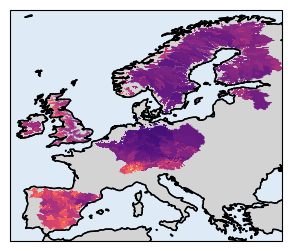

In [20]:
def plot_european_map_polygons_area(gdf, index_column, extent, cmap_color, vmin=None, vmax=None):
    # Clean the GeoDataFrame by dropping rows with missing values in the specified column
    gdf_cleaned = gdf.dropna(subset=[index_column])
    
    # Ensure the GeoDataFrame is in the correct CRS
    if gdf_cleaned.crs != "EPSG:4326":
        gdf_cleaned = gdf_cleaned.to_crs("EPSG:4326")
    
    # Calculate area and add it as a new column for sorting
    gdf_cleaned['area'] = gdf_cleaned.geometry.area
    
    # Sort the GeoDataFrame by area, smallest first
    gdf_cleaned = gdf_cleaned.sort_values(by='area',ascending=False)

    fig = plt.figure(figsize=(4.5, 3))
    # Change the projection to Lambert Conformal Conic for better representation of Europe
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.set_extent(extent, crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND, color="lightgrey")
    ax.add_feature(cfeature.OCEAN, color='#deebf7')
    ax.add_feature(cfeature.COASTLINE)
    
    # Get the minimum and maximum values of the index column for custom colormap limits
    if vmin is None:
        vmin = gdf_cleaned[index_column].min()
    if vmax is None:
        vmax = gdf_cleaned[index_column].max()
    
    # Create a colormap and normalization
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_color)
    
    # Plot each polygon, smallest area last (on top)
    for idx, row in gdf_cleaned.iterrows():
        ax.add_geometries([row.geometry], crs=ccrs.PlateCarree(), 
                          facecolor=cmap(norm(row[index_column])), 
                          edgecolor='white', linewidth=0.0001)

    # Create a ScalarMappable and add the colorbar
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm._A = []  # Dummy array for the ScalarMappable
    
    #cbar = plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.02, pad=0.04,shrink=0.6, extend='both')
    #cbar.set_label(index_column)

    ax.coastlines()

    plt.savefig(index_column+'.jpeg',dpi=1200)
    plt.show()
    

# Assuming 'merged' is your merged GeoDataFrame and 'index_column' is the column you want to plot
index_column = 'era5_avgprcp_rainy'  # Replace with your actual column name
extent = [-11.5, 32, 35, 72]   # Define the extent for the European map (min_lon, max_lon, min_lat, max_lat)
cmap_color = 'magma'  # Choose a colormap

# Call the function to plot the map
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=1, vmax=10)

C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\ashis\anaconda3\envs\new_env\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c

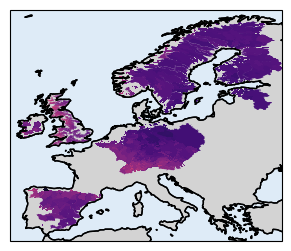

In [21]:
# Specify the index column to plot
index_column = 'y_sim_avgprcp_rainy'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=1, vmax=10)

C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\ashis\anaconda3\envs\new_env\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c

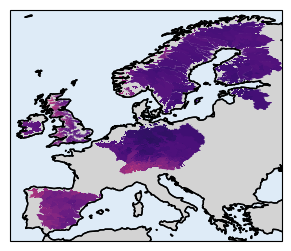

In [22]:
# Specify the index column to plot
index_column = 'y_sim_no_disch_avgprcp_rainy'  # Replace 'NSE' with the name of your index column

# Plot the world map
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=1, vmax=10)

C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\ashis\anaconda3\envs\new_env\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c

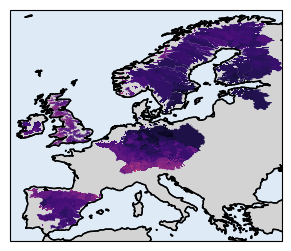

In [23]:
index_column = 'y_sim_r95p_1'
# Plot the world map
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=4, vmax=22)

C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_cleaned['area'] = gdf_cleaned.geometry.area
c:\Users\ashis\anaconda3\envs\new_env\lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\ashis\AppData\Local\Temp\ipykernel_28124\572008342.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  c

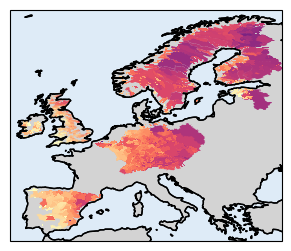

In [24]:
index_column = 'y_sim_spearman_lag1'
plot_european_map_polygons_area(merged, index_column, extent, cmap_color, vmin=0.2, vmax=0.7)